Enrico Convento -- id: 2023572

Load the following files to avoid to re-run the training:


*   par_pixels_no_reg
*   scores_pixels_no_reg
*   par_pixels_wd
*   scores_pixels_wd
*   par_pixels_dropout
*   scores_pixels_dropout


# Cart pole using pixles 

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import os
from tqdm.notebook import tqdm


import torch
from torch import nn
from torch import optim

import gym

from collections import deque, OrderedDict


seed = 0
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Colab setup

In [2]:
## Rendering section ##

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './videos', force=True, video_callable=video_callable)
  return env

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [3]:
### Enable video saving local  ###
from gym.wrappers.monitoring import video_recorder

class EnvWrapper():
  '''
  There is bugin the gym code that doesn't allow the proper usage of gym.wrappers.Monitor
  This class allows saving a video of the agent's behavior when using the local machine, by extending some functione of the gym environment.
  
  Agrs:
    env: gym environment
    video_path: string, where to save the video

  '''

  def __init__(self, env, video_path):
    self.env = env
    self.vid = video_recorder.VideoRecorder(self.env,path=video_path)

  def close(self):
    self.vid.close()
    return self.env.close()

  def reset(self):
    return self.env.reset()

  def seed(self, seed):
    return self.env.seed(seed)

  def step(self, *args, **kwargs):
    return self.env.step(*args, **kwargs)

  def render(self, mode='human'):
    r = self.env.render(mode)
    self.vid.capture_frame()
    return r

In [4]:
from torchvision import transforms

os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # solving a bug of colab.

In [5]:
use_gpu = True

# Check if the GPU is available
device = torch.device("cuda") if (torch.cuda.is_available() and use_gpu) else torch.device("cpu")
if use_gpu:
  print(f"Training device: {device}: {torch.cuda.get_device_name(0)}")
else:
  print(f'Training device: {device}')

Training device: cuda: Tesla K80


## Preprocessing the screen pixels

In [6]:
class Crop():
  '''
  Crop an image in the x, y and color dimensions.

  Args:
    x_crop
    y_crop
    c_crop
      every one of them needs to be None or a tuple (min, max), where min is inclusive and max exclusive
  '''

  def __init__(self, x_crop=None, y_crop=None, c_crop=None):
    self.x_crop = x_crop
    self.y_crop = y_crop
    self.c_crop = c_crop

  def __call__(self, img):
    if self.x_crop is None:
      self.x_crop = (0, img.shape[1])
    if self.y_crop is None:
      self.y_crop = (0, img.shape[0])
    if self.c_crop is None:
      self.c_crop = (0, img.shape[2])

    return img[self.y_crop[0]:self.y_crop[1], self.x_crop[0]:self.x_crop[1], self.c_crop[0]:self.c_crop[1]]

class Downsample():
  '''
  Downsamples an image in the x and y dimensions.

  Args:
    downsample_x
    downsample_y:
      both int (default 1)
  '''

  def __init__(self, downsample_x=1, downsample_y=1):
    self.downsample_x = downsample_x
    self.downsample_y = downsample_y

  def __call__(self, pic):
    return pic[::self.downsample_y, ::self.downsample_x, :]


# notice that if a device is available the class below create tensor exploiting 
# the device, since it save images this could leads to some complication with
# the memory provided in Colab
class ScreenPreprocesser():
  '''
  Preprocesses the images

  Args:
    transform: transformation to be aplied to the images
    device: device on which to create the final tensor
    negative: bool (default False)
      whether to make the negative of the images
  '''

  def __init__(self, transform=None, device=None, negative=False):
    self.transform = transform
    self.device = device
    self.negative = negative

  def __call__(self, img):
    if self.transform is not None:
      img = self.transform(img)
    
    img = torch.tensor(img/255, dtype=torch.float32, device=self.device, requires_grad=False).permute([2,0,1])
    if self.negative:
      img = 1 - img
    return img

In [7]:
### TEST ###
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")
env.reset()
env.step(0)
orig_img = env.render(mode='rgb_array') ## Take picture of screen
env.close()

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2



Preprocessing structure:

*   Crop x between 100 and 500
*   Crop y between 160 and 320
*   Gray scale conversion 
*   Negative trasform
*   Downsampling the y axis, i.e. keeping only one row of pixels every 6 of them
*   x axis not downsampled





In [8]:
transform = transforms.Compose([
                               Crop(y_crop=(160,320), c_crop=(2,3), x_crop=(100, 500)),
                               Downsample(downsample_x=1, downsample_y=6)
])

screen_prep = ScreenPreprocesser(transform, device=device, negative=True)

print(f"Initial image shape: {orig_img.shape}")

img = screen_prep(orig_img)

input_shape = tuple(img.shape)
print(f"Processed image shape: {input_shape}")

Initial image shape: (400, 600, 3)
Processed image shape: (1, 27, 400)


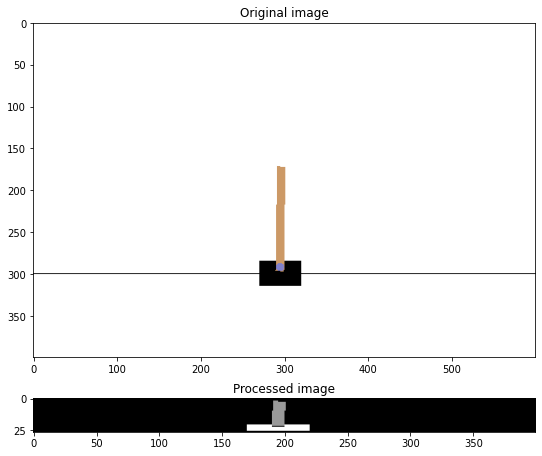

In [9]:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(9,8))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,:])
ax2 = fig.add_subplot(gs[4:,:])

ax1.imshow(orig_img)
ax1.title.set_text("Original image")
ax2.imshow(img.squeeze().cpu().numpy(), cmap='gist_gray')
ax2.title.set_text("Processed image")

## Experience repaly

In [10]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Policies

In [11]:
def random_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, ignored

  Returns a random value from 0 to len(q_values) - 1
  '''
  return np.random.randint(q_values.shape[-1])

def greedy_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, ignored

  Returns the argmax of q_values
  '''
  return int(q_values.argmax())


def softmax_policy(q_values, temp):
  '''
  Args:
    q_values: array like
    temp: float, temperature of the softmax

  Returns:
    'a' with probability proportional to exp(q_values[a]/temp)
  '''
  if temp < 0:
    raise ValueError(f'temperature must be >= 0, not {temp}')
  if temp == 0:
    return greedy_policy(q_values, temp)

  temp = max(temp, 1e-8) # for numerical stability
  softmax_out = nn.functional.softmax(q_values/temp, dim=0).cpu().numpy()

  return np.random.choice(np.arange(softmax_out.shape[-1]), p=softmax_out)

## Network

In [12]:
class CNN(nn.Module):
  '''
  Convolutional neural network
  '''
  def __init__(self, channels=[], kernel_sizes=[], strides=[], paddings=[], Nhs=[], activation_function=nn.ReLU, No=10, o_act=nn.Identity(), input_shape=(1, 28, 28)):
    super().__init__()

    self.shapes = [input_shape]

    ### Convolutional layer

    ## Create an ordered dictionary with the layers
    self.conv_od = OrderedDict([])
    for i,c in enumerate(channels):
      # add convolutional layer
      if i == 0:
        self.conv_od.update({'conv1': nn.Conv2d(in_channels=self.shapes[0][0],out_channels=channels[0],
                                                       kernel_size=kernel_sizes[0], stride = strides[0], padding=paddings[0])})
      else:
        self.conv_od.update({f'conv{i + 1}': nn.Conv2d(in_channels=channels[i - 1],out_channels=c,
                                                       kernel_size=kernel_sizes[i], stride = strides[i], padding=paddings[i])})
      next_size_1 = (self.shapes[-1][1] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      next_size_2 = (self.shapes[-1][2] + 2*paddings[i] - kernel_sizes[i])//strides[i] + 1
      self.shapes.append((c, next_size_1, next_size_2))
      if next_size_1 < 1 or next_size_2 < 1:
        raise TypeError(f'Shape flow interrupted: {self.shapes}')
      # add activation function
      self.conv_od.update({f'conv_act{i + 1}': activation_function()})

    ## Create a sequential layer
    self.conv_layers = nn.Sequential(self.conv_od)


    ### Flatten

    self.flatten = nn.Flatten(start_dim=1)
    self.shapes.append(np.product(self.shapes[-1]))


    ### Linear fc layers

    ## Create ordered dictionary with the layers
    self.lin_od = OrderedDict([])
    _Nhs = [self.shapes[-1]] + Nhs
    for i in range(1,len(_Nhs)):
      # add linear layer
      self.lin_od.update({f'lin{i}': nn.Linear(in_features=_Nhs[i - 1], out_features=_Nhs[i])})
      self.shapes.append(_Nhs[i])

      # add activation function
      self.lin_od.update({f'lin_act{i}': activation_function()})

    ## Create a sequential layer
    self.lin_layers = nn.Sequential(self.lin_od)


    ## Create the output layer
    self.out = nn.Linear(in_features=_Nhs[-1], out_features=No)
    self.o_act = o_act
    self.shapes.append(No)


  def forward(self, x):
    # apply convolutional layers
    x = self.conv_layers(x)

    # flatten
    x = self.flatten(x)

    # apply linear layers
    x = self.lin_layers(x)

    # output layer
    x = self.o_act(self.out(x))
    return x

## Exploration profile

In [13]:
class ExplorationProfile():
  '''
  Temperature decays exponentially from 'start_value' to 'start_value'*exp(-'lam') over 'max_iterations' episodes.
  '''

  def __init__(self, max_iterations=1000, start_value=1, lam=10):
    
    exp_decay = np.exp(-lam/max_iterations)
    self.profile = [start_value * (exp_decay ** i) for i in range(max_iterations)]

  def __len__(self):
    return len(self.profile)

  def __getitem__(self, idx):
    return self.profile[idx]

  def update(self, training):
    '''
    In this base version does nothing
    '''
    return

  def plot(self):
    plt.figure(figsize=(12,8))
    plt.plot(self.profile)
    plt.grid()
    plt.xlabel('Iteration')
    plt.ylabel('Exploration profile')





Text(0, 0.5, 'Exploration profile (Softmax temperature)')

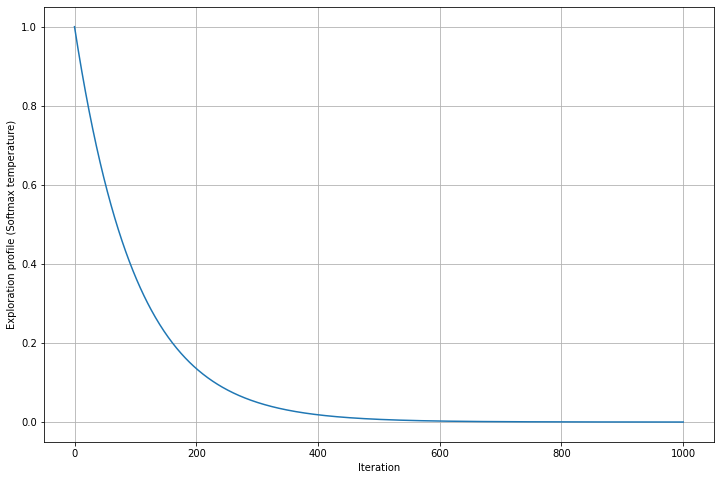

In [14]:
exploration_profile = ExplorationProfile(max_iterations=1000, start_value=1, lam=10)
exploration_profile.max_iterations = 1000
exploration_profile.profile.append(1e-6)

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Agent 


In [15]:
class Agent():
  '''
  Class for handling the interaction with a gym environment

  Args:
    environment:  environment
    policy_net:  network
    policy
    screen_preprocesser: class for preprocessing the screen pixels, if None (default) the high level information is used, otherwise the pixels are used
  '''

  def __init__(self, environment, policy_net, policy=None, screen_preprocesser=None):
    self.env = environment
    self.policy_net = policy_net
    self.policy = policy

    self.screen_preprocesser = screen_preprocesser

    self.score = 0
    self.cumulated_reward = 0
    self.t = 0

    self.reward = 0
    self.state = None

    self.aux_state = None # is the normal state when using pixels
    self.aux_next_state = None

    self.action = None
    self.next_state = None
    self.q_values = None

    self.is_ready = False

  def episode(self, temp=0, max_score=500, min_score=-np.infty, modifier= None, verbose=True):
    '''
    Runs a single episode on the environment.

    Args:
      temp:  temperature 
      max_score
      min_score
        --- > stop interaction with the environment when score >= max_score or score <= min_score
      modifier: None or function
        **modifies -- > reward 
                      score of the agent 
                      optimizing the policy net parameters 
                      push samples to the replay memory
      verbose: bool (default True)
    '''


    self.t = 0
    self.score = 0
    self.cumulated_reward = 0
    self.q_values = torch.zeros(self.policy_net.shapes[-1], dtype=torch.float32)
    self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net
    done = False

    #  using pixels
    self.aux_state = self.env.reset()
    self.state = self.screen_preprocesser(self.env.render(mode='rgb_array'))
    

    while not done and self.score < max_score and self.score > min_score:
      try:
        # compute q values
        self.policy_net.eval()
        with torch.no_grad():
          # we are using pixels
          self.q_values = self.policy_net(self.state.unsqueeze(0)).squeeze()

        # choose action
        self.action = self.policy(self.q_values, temp)
        self.is_ready = True
      except KeyboardInterrupt:
        raise KeyboardInterrupt
      except:
        self.is_ready = False
        self.action = random_policy(self.q_values, 0) # select first action randomly in case the agent cannot evaluate the policy net


      # apply action
      self.next_state, self.reward, done, info = self.env.step(self.action)
      # we are using pixels
      self.aux_next_state = np.copy(self.next_state)
      self.next_state = self.screen_preprocesser(self.env.render(mode='rgb_array'))
      


      if done:
        self.next_state = None

      # call the modifier
      if modifier == None:
        agent.score += 1
      else:
        modifier(self)

      # update cumulated reward
      self.cumulated_reward += self.reward
      
      self.state = self.next_state
      self.aux_state = self.aux_next_state

      self.t += 1

    if verbose:
      print(f'--- score: {self.score}')



# Training



In [16]:
class Training():
  '''
  Class for handling the training of an agent.

  Args:
    agent: Agent
    target_net: net to be used for computing expected Q-values.
    update_target_net_every: int (default 10):
      number of episodes every which to update the target net

    optimizer_type: e.g. optim.SGD
    optimizer_params: dictionary
    loss_function: e.g. nn.MSELoss()

    memory_capacity: int (default 10000):
      maximum number of samples for the replay memory
    min_samples: int (default 1000):
      minimum number of samples in the replay memory to start training the agent
    batch_size: int (default 256)

    discount_rate: float (default 0.97)

    gradient_clip_value: float (default 2):
      Clips the norm of the gradient of the weight of the training net

    score_to_beat: float (default 500):
      minimum score by the agent at the end of an episode for considering the game beaten


    device: GPU or CPU: default None, i.e. CPU
  '''

  ## Initialization 
  def __init__(self, agent, target_net, optimizer_type, optimizer_params, loss_function, 
               memory_capacity=10000, min_samples=1000, batch_size=256,
               discount_rate=0.97, gradient_clip_value=2,
               score_to_beat=500, update_target_net_every=10, device=None,
               position_weight=0, position_exponent=1, angle_weight=0, angle_exponent=1, end_state_penalty=0,
               consecutive_frames=1, push_to_mem_every=1, max_score_for_pushing=np.infty):
    
    self.agent = agent
    self.target_net = target_net
    self.target_net.load_state_dict(self.agent.policy_net.state_dict())
    #optimizer_params['weight_decay'] = 0.0001
    self.optimizer = optimizer_type(self.agent.policy_net.parameters(), **optimizer_params)
    print(self.optimizer)
    
    self.loss_function = loss_function

    self.replay_mem = ReplayMemory(memory_capacity)
    self.min_samples = min_samples
    self.batch_size = batch_size

    self.discount_rate = discount_rate
    self.gradient_clip_value = gradient_clip_value

    self.device = device

    self.episode_num = 0
    self.perfect_consecutive_episodes = 0

    self.score_to_beat = score_to_beat
    self.update_target_net_every = update_target_net_every

    self.score_log = []
    self.cumulated_reward_log = []


    self.pos_w = position_weight
    self.pos_exp = position_exponent
    self.ang_w = angle_weight
    self.ang_exp = angle_exponent
    self.end_state_penalty = end_state_penalty


    self.consecutive_frames = deque(maxlen=consecutive_frames)
    self.push_to_mem_every = push_to_mem_every
    self.max_score_for_pushing = max_score_for_pushing

  def __len__(self):
    return len(self.score_log)

  def give_reward(self, agent):
    agent.score += 1

    # check if the agent beated the game
    if self.agent.score >= self.score_to_beat:
      self.perfect_consecutive_episodes += 1
      agent.reward +=1
    else:
      self.perfect_consecutive_episodes = 0

    if agent.next_state is None:
      agent.reward += self.end_state_penalty
    else:
      agent.reward += self.pos_w*np.abs(agent.aux_next_state[0])**self.pos_exp + self.ang_w*np.abs(agent.aux_next_state[2])**self.ang_exp

  def modifier(self, agent):
    # modify the reward of the agent: e.g. add penalties
    self.give_reward(agent)

    if agent.t == 0: # empty the deque at the beginning of every episode
      self.consecutive_frames.clear()

    if agent.next_state is not None:
      self.consecutive_frames.append(agent.next_state)
      agent.next_state = torch.cat(list(self.consecutive_frames))

    # add new samples to the replay memory
    if agent.is_ready and agent.t % self.push_to_mem_every == 0:
      if not (len(self.score_log) > 0 and self.score_log[-1] > self.max_score_for_pushing):
        self.replay_mem.push(agent.state, agent.action, agent.next_state, agent.reward)
    
    if len(self.replay_mem) == self.min_samples:
      print('\n\nInitiating learning\n\n')
    if len(self.replay_mem) > self.min_samples:
      # update policy net
      self.update_step()

    

 
  def update_target_net(self, verbose=False):
    if self.episode_num % self.update_target_net_every == 0:
      if verbose:
        print('Updating target net')
      self.target_net.load_state_dict(self.agent.policy_net.state_dict())


  def train(self, profile, verbose=False, min_perfect_episodes=10,  max_score=500, min_score=-np.infty):
    '''
    Train the agent:

    Args:
      profile: ExplorationProfile 
      verbose: bool (default False)
      min_perfect_episodes: int (default 10):
        when the agent beats the game for min_perfect_episodes consecutive episodes learning stops.
    Parameters that are simply passed to agent.episode:
        
        max_score
        min_score
    '''
    if self.device is not None:
      self.agent.policy_net.to(self.device)
      self.target_net.to(device)

    while self.episode_num < len(profile):
      temp = profile[self.episode_num]
      if verbose:
        print(f'Episode {self.episode_num}: temperature = {temp :.3e} ',end='')


      # run an episode
      self.agent.episode(temp=temp, max_score=max_score, min_score=min_score, 
                         modifier=self.modifier, verbose=verbose)

      # update target net
      self.update_target_net(verbose=verbose)

      

      self.episode_num += 1
      self.score_log.append(self.agent.score)
      self.cumulated_reward_log.append(self.agent.cumulated_reward)

      # update the temp profile
      profile.update(self)

      # stop updating if the agent consistently beats the game
      if self.perfect_consecutive_episodes == min_perfect_episodes:
        if verbose:
          print('\n\n Game consistently beaten')
        break

  ## Network update
  def update_step(self):
    '''
    Updates the policy net of the agent
    '''

    # Sample the data from the replay memory
    batch = self.replay_mem.sample(self.batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states                = torch.stack([s[0] for s in batch])
    non_final_next_states = torch.stack([s[2] for s in batch if s[2] is not None])
    

    actions                 = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=self.device)
    rewards                 = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=self.device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool, device=self.device)

    # Compute all the Q values (forward pass)
    self.agent.policy_net.train()
    q_values = self.agent.policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      self.target_net.eval()
      q_values_target = self.target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=self.device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * self.discount_rate)
    # Set the required tensor shape
    expected_state_action_values = expected_state_action_values.unsqueeze(1)

    # Compute the Huber loss
    loss = self.loss_function(state_action_values, expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (for training stability)
    if self.gradient_clip_value > 0:
      nn.utils.clip_grad_norm_(self.agent.policy_net.parameters(), self.gradient_clip_value)
    self.optimizer.step()

    del loss
    del q_values
    del state_action_values
    torch.cuda.empty_cache()

# Training

## No regularization

In [17]:
consecutive_frames = 4

input_shape = (consecutive_frames, input_shape[1], input_shape[2])

net_params = {'channels': [16,32,16], 'kernel_sizes': [4,4,4], 'strides': [2,2,2], 'paddings': [0,0,0],
              'Nhs': [256], 'No': action_space_dim, 'input_shape': input_shape}

policy_net = CNN(**net_params)
target_net = CNN(**net_params)

agent = Agent(gym.make('CartPole-v1'),policy_net,policy=softmax_policy, screen_preprocesser=screen_prep) # for now set the env to None

training_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.Adam, 'optimizer_params': {'lr': 3e-4},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 32,
                  'position_weight': -1.4, 'position_exponent': 2, 'angle_weight': -7, 'angle_exponent': 1, 'end_state_penalty': -10,
                  'device': device, 'memory_capacity': 4000, 'update_target_net_every': 5}

trainer = Training(**training_params, consecutive_frames=consecutive_frames, max_score_for_pushing=350)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0
)


In [ ]:
## Run this cell if you want to re-perform the training

agent.env.seed(0)
try:
  trainer.train(exploration_profile,verbose=True, min_perfect_episodes=20)
except KeyboardInterrupt:   
  print('\n\nTraining interrupted\n\n')
agent.env.close()

Episode 0: temperature = 1.000e+00 --- score: 19
Updating target net
Episode 1: temperature = 9.900e-01 --- score: 22
Episode 2: temperature = 9.802e-01 --- score: 26
Episode 3: temperature = 9.704e-01 --- score: 15
Episode 4: temperature = 9.608e-01 --- score: 12
Episode 5: temperature = 9.512e-01 --- score: 30
Updating target net
Episode 6: temperature = 9.418e-01 --- score: 22
Episode 7: temperature = 9.324e-01 --- score: 34
Episode 8: temperature = 9.231e-01 --- score: 12
Episode 9: temperature = 9.139e-01 --- score: 12
Episode 10: temperature = 9.048e-01 --- score: 17
Updating target net
Episode 11: temperature = 8.958e-01 --- score: 19
Episode 12: temperature = 8.869e-01 --- score: 14
Episode 13: temperature = 8.781e-01 --- score: 24
Episode 14: temperature = 8.694e-01 --- score: 13
Episode 15: temperature = 8.607e-01 --- score: 17
Updating target net
Episode 16: temperature = 8.521e-01 

In [ ]:
agent.env.close()

In [18]:
## Saving model ##
#torch.save(trainer.agent.policy_net.state_dict(), 'par_pixel_no_reg')

## Load model ##
trainer.agent.policy_net.load_state_dict(torch.load('par_pixel_no_reg'))

<All keys matched successfully>

In [19]:
import pickle
## SAVE SCORES  ##

#with open("scores_pixel_no_reg", "wb") as fp:   #Pickling
#  pickle.dump(trainer.score_log, fp)


## LOAD SCORES  ##
with open("scores_pixel_no_reg", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)

### Results

Text(0, 0.5, 'T profile')

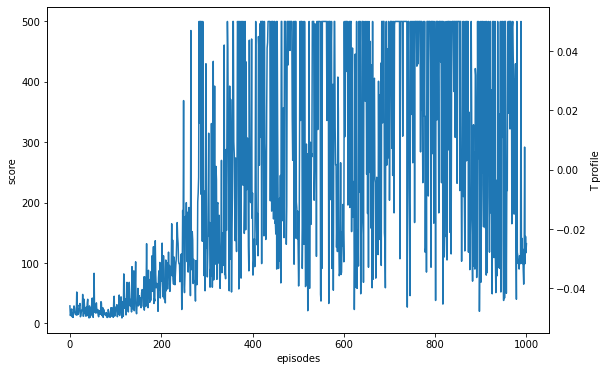

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(episodes_trajectories)

ax.set_ylabel('score' )
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile.profile[:len(trainer.score_log)], color='purple', linestyle='dotted')
ax2.set_ylabel('T profile')

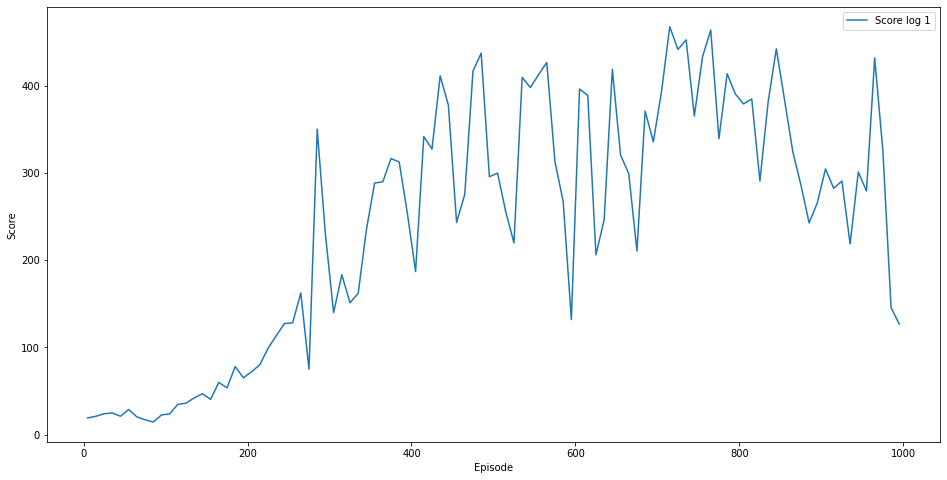

In [21]:
def averaging(signal, freq=10):
    new_signal = []
    new_pos = []
    for i in range(len(signal)//freq):
        new_signal.append( signal[i*freq:(i+1)*freq].mean() )
        new_pos.append( (i*freq+(i+1)*freq)/2 )
    return new_pos, new_signal
t = np.arange(0, 1000, 1)

fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Episode')
ax.set_ylabel('Score')
trial_counter = 1;

x, y = averaging(np.array(episodes_trajectories))
ax.plot(x, y, label="Score log {}".format(trial_counter))
trial_counter += 1

ax.legend()

### Test

In [22]:
class mod():

  def __init__(self, consecutive_frames=1):
    self.consecutive_frames = deque(maxlen=consecutive_frames)

  def __call__(self, agent):
    agent.score += 1

    # make the the deque empty at the beginning of every episode
    if agent.t == 0: 
      self.consecutive_frames.clear()

    if agent.next_state is not None:
      self.consecutive_frames.append(agent.next_state)
      agent.next_state = torch.cat(list(self.consecutive_frames))

In [23]:
trainer.agent.policy_net.to(device)

scores = []
for i in range(100):
  trainer.agent.episode(temp=0, modifier=mod(4))
  scores.append(trainer.agent.score)
trainer.agent.env.close()

print('\n\n\n############################### \n      MEAN SCORE:  ', np.mean(scores),'\n###############################')

--- score: 500
--- score: 88
--- score: 89
--- score: 459
--- score: 368
--- score: 107
--- score: 222
--- score: 92
--- score: 144
--- score: 218
--- score: 500
--- score: 500
--- score: 127
--- score: 217
--- score: 339
--- score: 262
--- score: 385
--- score: 149
--- score: 121
--- score: 184
--- score: 154
--- score: 431
--- score: 500
--- score: 263
--- score: 143
--- score: 367
--- score: 500
--- score: 120
--- score: 124
--- score: 153
--- score: 500
--- score: 131
--- score: 500
--- score: 123
--- score: 114
--- score: 132
--- score: 367
--- score: 61
--- score: 500
--- score: 500
--- score: 334
--- score: 172
--- score: 163
--- score: 385
--- score: 150
--- score: 500
--- score: 455
--- score: 500
--- score: 138
--- score: 500
--- score: 134
--- score: 282
--- score: 213
--- score: 500
--- score: 500
--- score: 84
--- score: 124
--- score: 352
--- score: 452
--- score: 123
--- score: 84
--- score: 160
--- score: 493
--- score: 61
--- score: 110
--- score: 500
--- score: 69
---

## Weight decay

In [24]:
consecutive_frames = 4

input_shape = (consecutive_frames, input_shape[1], input_shape[2])

net_params = {'channels': [16,64,64], 'kernel_sizes': [4,4,4], 'strides': [2,2,2], 'paddings': [0,0,0],
              'Nhs': [256], 'No': action_space_dim, 'input_shape': input_shape}

policy_net = CNN(**net_params)
target_net = CNN(**net_params)

agent = Agent(gym.make('CartPole-v1'),policy_net,policy=softmax_policy, screen_preprocesser=screen_prep) # for now set the env to None

training_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.Adam, 'optimizer_params': {'lr': 3e-4, 'weight_decay' : 0.0001},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 32,
                  'position_weight': -1.4, 'position_exponent': 2, 'angle_weight': -7, 'angle_exponent': 1, 'end_state_penalty': -10,
                  'device': device, 'memory_capacity': 4000, 'update_target_net_every': 5}

trainer = Training(**training_params, consecutive_frames=consecutive_frames, max_score_for_pushing=350)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0.0001
)


In [ ]:
## Run this cell if you want to re-perform the training

agent.env.seed(0)
try:
  trainer.train(exploration_profile,verbose=True, min_perfect_episodes=20)
except KeyboardInterrupt:   
  print('\n\nTraining interrupted\n\n')
agent.env.close()

Episode 0: temperature = 1.000e+00 --- score: 19
Updating target net
Episode 1: temperature = 9.900e-01 --- score: 22
Episode 2: temperature = 9.802e-01 --- score: 26
Episode 3: temperature = 9.704e-01 --- score: 15
Episode 4: temperature = 9.608e-01 --- score: 12
Episode 5: temperature = 9.512e-01 --- score: 30
Updating target net
Episode 6: temperature = 9.418e-01 --- score: 22
Episode 7: temperature = 9.324e-01 --- score: 34
Episode 8: temperature = 9.231e-01 --- score: 12
Episode 9: temperature = 9.139e-01 --- score: 12
Episode 10: temperature = 9.048e-01 --- score: 17
Updating target net
Episode 11: temperature = 8.958e-01 --- score: 19
Episode 12: temperature = 8.869e-01 --- score: 14
Episode 13: temperature = 8.781e-01 --- score: 24
Episode 14: temperature = 8.694e-01 --- score: 13
Episode 15: temperature = 8.607e-01 --- score: 17
Updating target net
Episode 16: temperature = 8.521e-01 --- score: 17
Episode 17: temperature = 8.437e-01 --- score: 15
Episode 18: temperature = 8.35

In [ ]:
agent.env.close()

In [25]:
## Saving model ##
#torch.save(trainer.agent.policy_net.state_dict(), 'par_pixel_wd')

## Load model ##
trainer.agent.policy_net.load_state_dict(torch.load('par_pixel_wd'))


<All keys matched successfully>

In [26]:
import pickle
## SAVE SCORES AND PARAMS ##

#with open("scores_pixel_wd", "wb") as fp:   #Pickling
#  pickle.dump(trainer.score_log, fp)


## LOAD SCORES AND PARAMS ##
with open("scores_pixel_wd", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)


### Results

Text(0, 0.5, 'T profile')

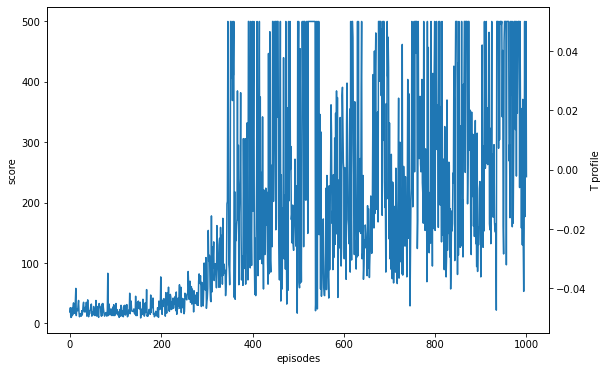

In [27]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(episodes_trajectories)

ax.set_ylabel('score' )
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile.profile[:len(trainer.score_log)], color='purple', linestyle='dotted')
ax2.set_ylabel('T profile')

### Test

In [28]:
trainer.agent.policy_net.to(device)

scores = []
for i in range(100):
  trainer.agent.episode(temp=0, modifier=mod(4))
  scores.append(trainer.agent.score)
trainer.agent.env.close()

print('\n\n\n############################### \n      MEAN SCORE:  ', np.mean(scores),'\n###############################')

--- score: 278
--- score: 360
--- score: 197
--- score: 190
--- score: 321
--- score: 166
--- score: 500
--- score: 228
--- score: 458
--- score: 23
--- score: 113
--- score: 500
--- score: 141
--- score: 357
--- score: 500
--- score: 173
--- score: 401
--- score: 80
--- score: 186
--- score: 104
--- score: 500
--- score: 55
--- score: 279
--- score: 500
--- score: 498
--- score: 500
--- score: 476
--- score: 181
--- score: 491
--- score: 295
--- score: 500
--- score: 117
--- score: 375
--- score: 179
--- score: 127
--- score: 421
--- score: 500
--- score: 500
--- score: 45
--- score: 174
--- score: 500
--- score: 321
--- score: 150
--- score: 366
--- score: 366
--- score: 95
--- score: 71
--- score: 500
--- score: 68
--- score: 116
--- score: 500
--- score: 138
--- score: 218
--- score: 500
--- score: 97
--- score: 500
--- score: 247
--- score: 416
--- score: 119
--- score: 208
--- score: 364
--- score: 333
--- score: 500
--- score: 175
--- score: 500
--- score: 500
--- score: 264
---

## Weight decay + dropout

In [29]:
class CNN_d(CNN):
  '''
  Adds a Dropout 
  '''

  def __init__(self, *args, dropouts_probabilities=[], **kwargs):
    super().__init__(**kwargs)
    
    self.d_od = OrderedDict()

    i = 0
    for k,l in self.lin_od.items():
      if not k.startswith('lin_act') and i < len(dropouts_probabilities):
        self.d_od.update({f'dropout{i+1}': nn.Dropout(dropouts_probabilities[i])})
        i += 1
      self.d_od.update({k: l})

    self.lin_layers = nn.Sequential(self.d_od)

In [30]:
consecutive_frames = 4

input_shape = (consecutive_frames, input_shape[1], input_shape[2])

net_params = {'channels': [16,32,64], 'kernel_sizes': [4,4,4], 'strides': [2,2,2], 'paddings': [0,0,0],
              'Nhs': [256], 'No': action_space_dim, 'input_shape': input_shape}
add_params ={'dropout_probabilities' : [0.3,0.3]}
dropout_probabilities = [0.3,0.3]
policy_net = CNN_d(dropout_probabilities, **net_params)
target_net = CNN_d(dropout_probabilities, **net_params)

agent = Agent(gym.make('CartPole-v1'),policy_net,policy=softmax_policy, screen_preprocesser=screen_prep) # for now set the env to None

training_params = {'agent': agent, 'target_net': target_net, 'optimizer_type': optim.Adam, 'optimizer_params': {'lr': 3e-4, 'weight_decay' : 0.0001},
                  'loss_function': nn.SmoothL1Loss(), 'batch_size': 32,
                  'position_weight': -1.4, 'position_exponent': 2, 'angle_weight': -7, 'angle_exponent': 1, 'end_state_penalty': -10,
                  'device': device, 'memory_capacity': 4000, 'update_target_net_every': 5}

trainer = Training(**training_params, consecutive_frames=consecutive_frames, max_score_for_pushing=350)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 0.0001
)


In [ ]:
## Run this cell if you want to re-perform the training
agent.env.seed(0)
try:
  trainer.train(exploration_profile,verbose=True, min_perfect_episodes=20)
except KeyboardInterrupt:   
  print('\n\nTraining interrupted\n\n')
agent.env.close()

Episode 0: temperature = 1.000e+00 --- score: 17
Updating target net
Episode 1: temperature = 9.900e-01 --- score: 19
Episode 2: temperature = 9.802e-01 --- score: 13
Episode 3: temperature = 9.704e-01 --- score: 18
Episode 4: temperature = 9.608e-01 --- score: 12
Episode 5: temperature = 9.512e-01 --- score: 19
Updating target net
Episode 6: temperature = 9.418e-01 --- score: 16
Episode 7: temperature = 9.324e-01 --- score: 17
Episode 8: temperature = 9.231e-01 --- score: 18
Episode 9: temperature = 9.139e-01 --- score: 11
Episode 10: temperature = 9.048e-01 --- score: 11
Updating target net
Episode 11: temperature = 8.958e-01 --- score: 29
Episode 12: temperature = 8.869e-01 --- score: 24
Episode 13: temperature = 8.781e-01 --- score: 20
Episode 14: temperature = 8.694e-01 --- score: 25
Episode 15: temperature = 8.607e-01 --- score: 14
Updating target net
Episode 16: temperature = 8.521e-01 --- score: 22
Episode 17: temperature = 8.437e-01 --- score: 25
Episode 18: temperature = 8.35

In [31]:
## Saving model ##
#torch.save(trainer.agent.policy_net.state_dict(), 'par_pixel_dropout')

## Load model ##
trainer.agent.policy_net.load_state_dict(torch.load('par_pixel_dropout'))

<All keys matched successfully>

In [32]:
import pickle
## SAVE SCORES AND PARAMS ##

#with open("scores_pixel_dropout", "wb") as fp:   #Pickling
#  pickle.dump(trainer.score_log, fp)


## LOAD SCORES AND PARAMS ##
with open("scores_pixel_dropout", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)

### Results

Text(0, 0.5, 'T profile')

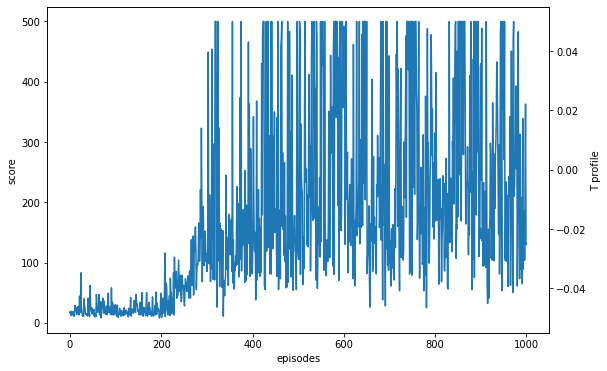

In [33]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(episodes_trajectories)

ax.set_ylabel('score' )
ax.set_xlabel('episodes')

ax2 = ax.twinx()
ax2.plot(exploration_profile.profile[:len(trainer.score_log)], color='purple', linestyle='dotted')
ax2.set_ylabel('T profile')

### Test

In [34]:
trainer.agent.policy_net.to(device)

scores = []
for i in range(100):
  trainer.agent.episode(temp=0, modifier=mod(4))
  scores.append(trainer.agent.score)
trainer.agent.env.close()

print('\n\n\n############################### \n      MEAN SCORE:  ', np.mean(scores),'\n###############################')

--- score: 145
--- score: 350
--- score: 84
--- score: 177
--- score: 500
--- score: 219
--- score: 367
--- score: 446
--- score: 253
--- score: 494
--- score: 217
--- score: 174
--- score: 84
--- score: 81
--- score: 130
--- score: 156
--- score: 344
--- score: 223
--- score: 336
--- score: 404
--- score: 457
--- score: 110
--- score: 500
--- score: 112
--- score: 450
--- score: 200
--- score: 500
--- score: 148
--- score: 307
--- score: 378
--- score: 423
--- score: 107
--- score: 129
--- score: 95
--- score: 58
--- score: 146
--- score: 500
--- score: 105
--- score: 436
--- score: 93
--- score: 500
--- score: 25
--- score: 500
--- score: 256
--- score: 452
--- score: 82
--- score: 224
--- score: 500
--- score: 172
--- score: 290
--- score: 211
--- score: 217
--- score: 173
--- score: 401
--- score: 104
--- score: 147
--- score: 500
--- score: 209
--- score: 456
--- score: 295
--- score: 129
--- score: 122
--- score: 330
--- score: 268
--- score: 189
--- score: 121
--- score: 500
---